<a href="https://colab.research.google.com/github/junexi0828/junexi0828.github.io/blob/main/%EC%B5%9C%EC%A2%85%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

In [3]:
!pip install matplotlib seaborn

## **1회 시행**

[Scenario 1] 대기시간: 평균:4.78분 (최대30.0분, 최소0.0분)
[Scenario 2] 대기시간: 평균:5.28분 (최대30.0분, 최소0.0분)
[Scenario 1] 총 주차시간 표준편차: 7.12분
[Scenario 2] 총 주차시간 표준편차: 7.54분


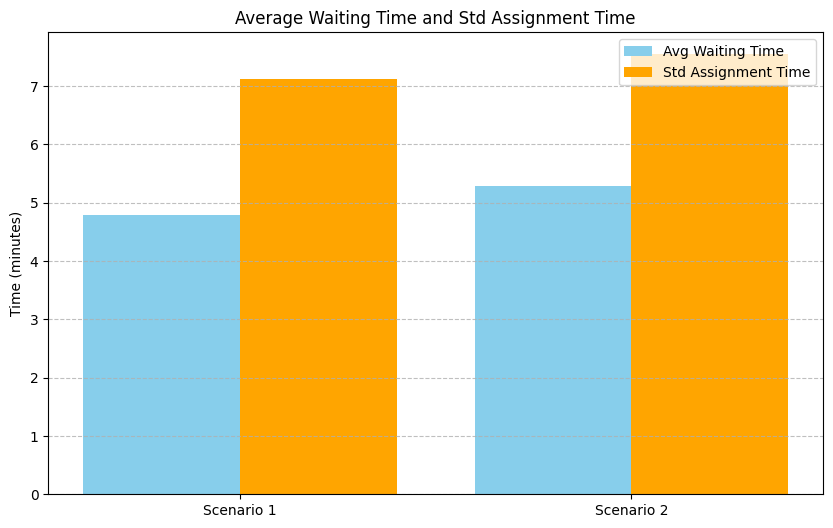

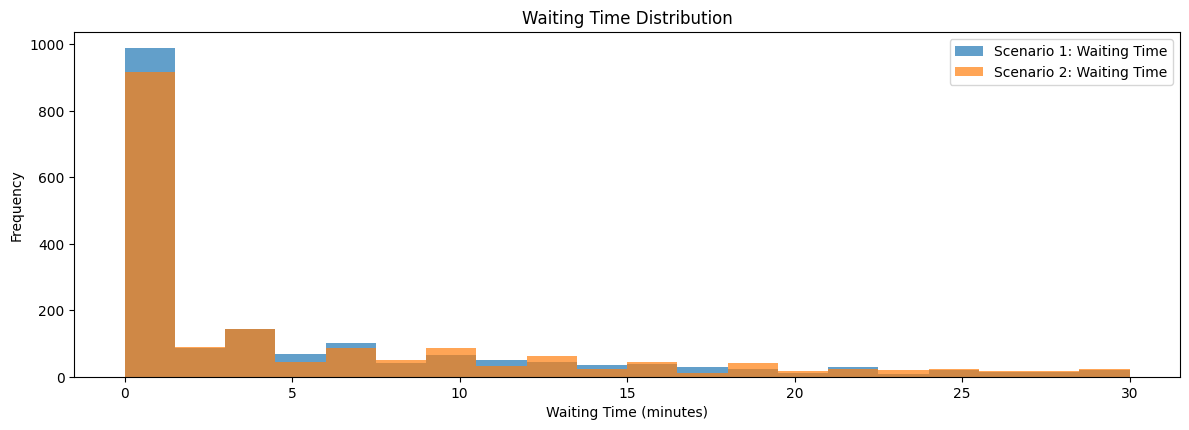

In [4]:
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

# 시뮬레이션 설정
SIMULATION_TIME = 600  # 총 시뮬레이션 시간 (분)
WARMUP_TIME = 240   # 웜업 시간 (4시간)
CAR_ARRIVAL_INTERVAL = 0.5  # 차량 도착 간격 평균 (분)
PARKING_DURATION = [30, 90]  # 주차 시간 범위 (분)
TOTAL_PARKING_SPOTS = 208

# 구역별 주차 공간 설정 (7개 구역)
zones_scenario_1 = {"All": {"capacity": TOTAL_PARKING_SPOTS, "occupied": 0}}
zones_scenario_2 = {
    "A": {"capacity": 32, "occupied": 0},
    "B": {"capacity": 32, "occupied": 0},
    "C": {"capacity": 32, "occupied": 0},
    "D": {"capacity": 32, "occupied": 0},
    "E": {"capacity": 32, "occupied": 0},
    "F": {"capacity": 32, "occupied": 0},
    "G": {"capacity": 16, "occupied": 0},
}

# 데이터 저장용
# assignment_time: 도착 → 대기 → 주차장 그리드에 차 넣을 때까지 걸린 시간
results = {
    "scenario_1": {"time": [], "occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
    "scenario_2": {"time": [], "total_occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
}

def bfs_parking(parking_lot):
    queue = deque()
    for zone_name, zone in parking_lot.items():
        if zone["occupied"] < zone["capacity"]:
            queue.append(zone_name)

    if queue:
        zone_name = queue.popleft()
        return zone_name
    else:
        return None  # 주차 공간이 없음

def car(env, car_id, parking_lot, result_data, scenario):
    arrival_time = env.now
    waiting_time_start = env.now
    MAX_WAITING_TIME = 30  # 대기 시간 최대 한도 (분)
    zone_name = bfs_parking(parking_lot)

    # 빈 자리 찾을 때까지 대기
    while not zone_name:
        yield env.timeout(1)
        if env.now - waiting_time_start > MAX_WAITING_TIME:
            # 대기 초과 시 포기
            #print(f"[상황 {scenario}] 차량 {car_id} 대기 초과로 포기. 대기: {round(env.now - waiting_time_start, 2)}분")
            return
        zone_name = bfs_parking(parking_lot)

    # 대기 시간
    waiting_time = env.now - waiting_time_start
    result_data["waiting_time"].append(waiting_time)

    # 차를 주차장 그리드에 넣는 순간 (점유 시작)
    parking_lot[zone_name]["occupied"] += 1
    # 이 시점이 곧 '도착→대기→그리드 배치' 완료 시점
    assignment_time = env.now - arrival_time
    result_data["assignment_time"].append(assignment_time)

    # 주차 시간 (차량이 주차장에 머무는 시간)
    parking_time = random.randint(*PARKING_DURATION)
    result_data["parking_time"].append(parking_time)

    yield env.timeout(parking_time)

    # 차량 출차
    parking_lot[zone_name]["occupied"] -= 1

    # 상황별 메시지
    #print(f"[상황 {scenario}] 차량 {car_id} 출차. 주차:{round(parking_time, 2)}분 대기:{round(waiting_time, 2)}분 배치시간:{round(assignment_time, 2)}분")

def simulate_scenario_1(env, parking_lot, result_data):
    car_id = 0
    while env.now < SIMULATION_TIME:
        yield env.timeout(random.expovariate(1.0 / CAR_ARRIVAL_INTERVAL))
        car_id += 1
        env.process(car(env, car_id, parking_lot, result_data, scenario=1))
        result_data["time"].append(env.now)
        result_data["occupancy"].append(parking_lot["All"]["occupied"])

def simulate_scenario_2(env, parking_lot, result_data):
    car_id = 0
    while env.now < SIMULATION_TIME:
        yield env.timeout(random.expovariate(1.0 / CAR_ARRIVAL_INTERVAL))
        car_id += 1
        env.process(car(env, car_id, parking_lot, result_data, scenario=2))
        result_data["time"].append(env.now)
        result_data["total_occupancy"].append(sum(zone["occupied"] for zone in parking_lot.values()))

def run_simulations():
    # 상황 1
    env_1 = simpy.Environment()
    env_1.process(simulate_scenario_1(env_1, zones_scenario_1, results["scenario_1"]))
    env_1.run(until=WARMUP_TIME)
    env_1.process(simulate_scenario_1(env_1, zones_scenario_1, results["scenario_1"]))
    env_1.run(until=WARMUP_TIME + SIMULATION_TIME)

    # 상황 2
    env_2 = simpy.Environment()
    env_2.process(simulate_scenario_2(env_2, zones_scenario_2, results["scenario_2"]))
    env_2.run(until=WARMUP_TIME)
    env_2.process(simulate_scenario_2(env_2, zones_scenario_2, results["scenario_2"]))
    env_2.run(until=WARMUP_TIME + SIMULATION_TIME)

    # 평균, 최대, 최소 값 계산
    avg_waiting_time_1 = np.mean(results["scenario_1"]["waiting_time"]) if results["scenario_1"]["waiting_time"] else 0
    max_waiting_time_1 = np.max(results["scenario_1"]["waiting_time"]) if results["scenario_1"]["waiting_time"] else 0
    min_waiting_time_1 = np.min(results["scenario_1"]["waiting_time"]) if results["scenario_1"]["waiting_time"] else 0

    avg_waiting_time_2 = np.mean(results["scenario_2"]["waiting_time"]) if results["scenario_2"]["waiting_time"] else 0
    max_waiting_time_2 = np.max(results["scenario_2"]["waiting_time"]) if results["scenario_2"]["waiting_time"] else 0
    min_waiting_time_2 = np.min(results["scenario_2"]["waiting_time"]) if results["scenario_2"]["waiting_time"] else 0

    # 표준편차 계산
    std_assignment_time_1 = np.std(results["scenario_1"]["assignment_time"]) if results["scenario_1"]["assignment_time"] else 0
    std_assignment_time_2 = np.std(results["scenario_2"]["assignment_time"]) if results["scenario_2"]["assignment_time"] else 0

    print(f"[Scenario 1] 대기시간: 평균:{round(avg_waiting_time_1, 2)}분 (최대{round(max_waiting_time_1, 2)}분, 최소{round(min_waiting_time_1, 2)}분)")
    print(f"[Scenario 2] 대기시간: 평균:{round(avg_waiting_time_2, 2)}분 (최대{round(max_waiting_time_2, 2)}분, 최소{round(min_waiting_time_2, 2)}분)")

    print(f"[Scenario 1] 총 주차시간 표준편차: {round(std_assignment_time_1, 2)}분")
    print(f"[Scenario 2] 총 주차시간 표준편차: {round(std_assignment_time_2, 2)}분")

        # 막대 그래프 추가
    categories = ['Scenario 1', 'Scenario 2']
    avg_waiting_times = [avg_waiting_time_1, avg_waiting_time_2]
    std_assignment_times = [std_assignment_time_1, std_assignment_time_2]

    x = np.arange(len(categories))  # x 좌표 생성

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, avg_waiting_times, width=0.4, label='Avg Waiting Time', color='skyblue')
    plt.bar(x + 0.2, std_assignment_times, width=0.4, label='Std Assignment Time', color='orange')

    plt.xticks(x, categories)
    plt.title("Average Waiting Time and Std Assignment Time")
    plt.ylabel("Time (minutes)")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.8) #알파 투명도 조절
    plt.show()

    # 대기 시간 및 배치 시간 히스토그램 추가
    plt.figure(figsize=(12, 8))

    # 대기 시간 히스토그램
    plt.subplot(2, 1, 1)
    plt.hist(results["scenario_1"]["waiting_time"], bins=20, alpha=0.7, label="Scenario 1: Waiting Time")
    plt.hist(results["scenario_2"]["waiting_time"], bins=20, alpha=0.7, label="Scenario 2: Waiting Time")
    plt.title("Waiting Time Distribution")
    plt.xlabel("Waiting Time (minutes)")
    plt.ylabel("Frequency")
    plt.legend()

    #디버깅,표준편차는 시간의 흐름으로 나타내면안됨. 배치 시간 히스토그램
    """plt.subplot(2, 1, 2)
    plt.hist(results["scenario_1"]["assignment_time"], bins=20, alpha=0.7, label="Scenario 1: Assignment Time")
    plt.hist(results["scenario_2"]["assignment_time"], bins=20, alpha=0.7, label="Scenario 2: Assignment Time")
    plt.title("Assignment Time Distribution")
    plt.xlabel("Assignment Time (minutes)")
    plt.ylabel("Frequency")
    plt.legend()"""

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_simulations()


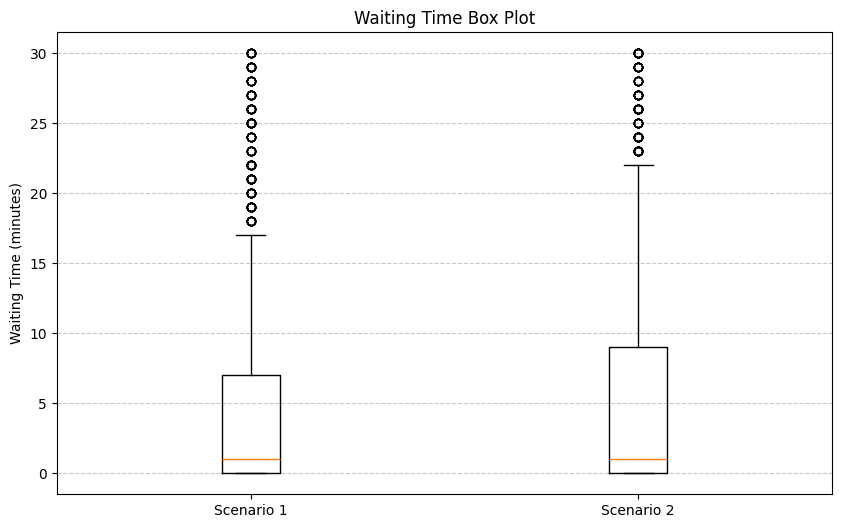

In [5]:
# 박스 플롯
plt.figure(figsize=(10, 6))
data = [
    results["scenario_1"]["waiting_time"],
    results["scenario_2"]["waiting_time"]
]
plt.boxplot(data, labels=["Scenario 1", "Scenario 2"])
plt.title("Waiting Time Box Plot")
plt.ylabel("Waiting Time (minutes)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


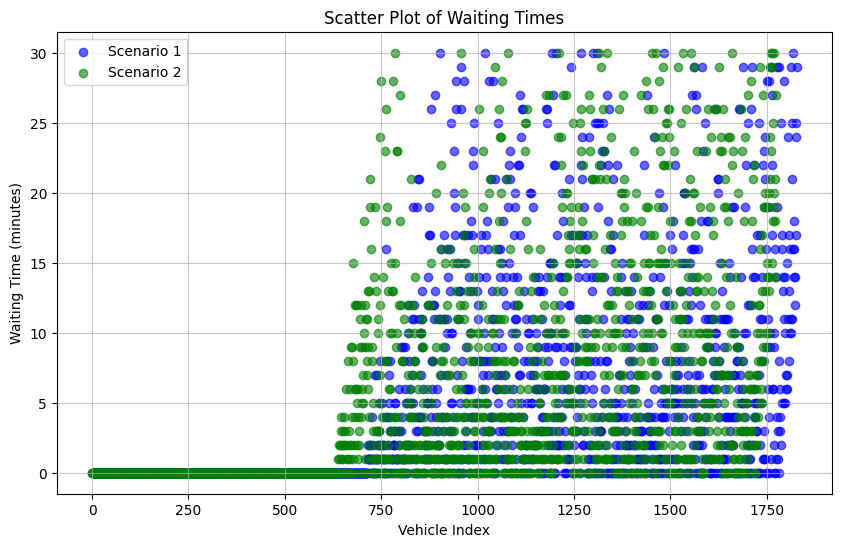

In [6]:
# 산점도
plt.figure(figsize=(10, 6))
plt.scatter(range(len(results["scenario_1"]["waiting_time"])), results["scenario_1"]["waiting_time"], alpha=0.6, label="Scenario 1", color="blue")
plt.scatter(range(len(results["scenario_2"]["waiting_time"])), results["scenario_2"]["waiting_time"], alpha=0.6, label="Scenario 2", color="green")
plt.title("Scatter Plot of Waiting Times")
plt.xlabel("Vehicle Index")
plt.ylabel("Waiting Time (minutes)")
plt.legend()
plt.grid(alpha=0.7)
plt.show()


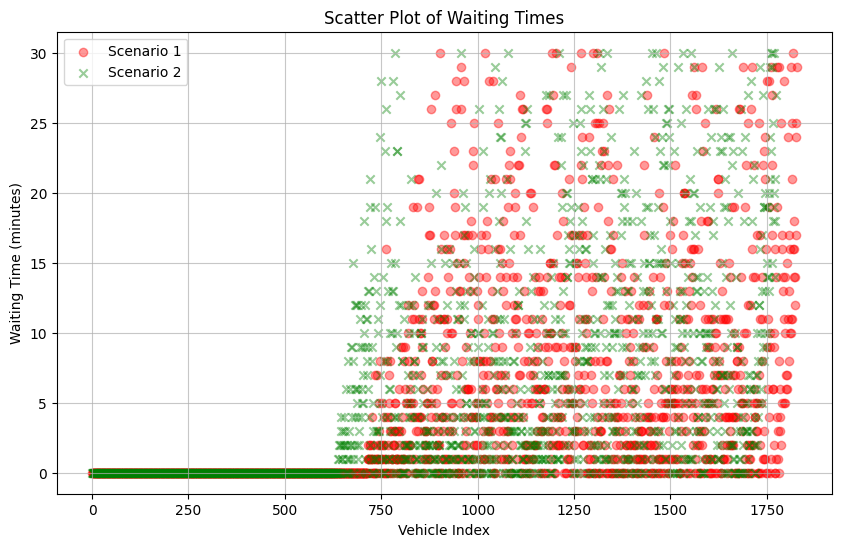

In [7]:
# 산점도 - 서로 다른 마커 추가
plt.figure(figsize=(10, 6))
plt.scatter(
    range(len(results["scenario_1"]["waiting_time"])),
    results["scenario_1"]["waiting_time"],
    alpha=0.4,
    label="Scenario 1",
    color="red",
    marker="o"  # Scenario 1: 원형 마커
)
plt.scatter(
    range(len(results["scenario_2"]["waiting_time"])),
    results["scenario_2"]["waiting_time"],
    alpha=0.4,
    label="Scenario 2",
    color="green",
    marker="x"  # Scenario 2: X형 마커
)
plt.title("Scatter Plot of Waiting Times")
plt.xlabel("Vehicle Index")
plt.ylabel("Waiting Time (minutes)")
plt.legend()
plt.grid(alpha=0.7)
plt.show()

# **50회시행**

<비교분석을 위한 단일 시행, 데이터 추출>
[Scenario 1] 대기시간, 평균:4.70분 (중앙값:0.89분)
[Scenario 2] 대기시간, 평균:4.80분 (중앙값:0.92분)
[Scenario 1] 총 주차시간, 평균:7.07분, 표준편차:0.41
[Scenario 2] 총 주차시간, 평균:7.17분, 표준편차:0.44

--- 50회 시뮬레이션 결과 요약 ---


<50번 시행 데이터 추출기반, 그래프>


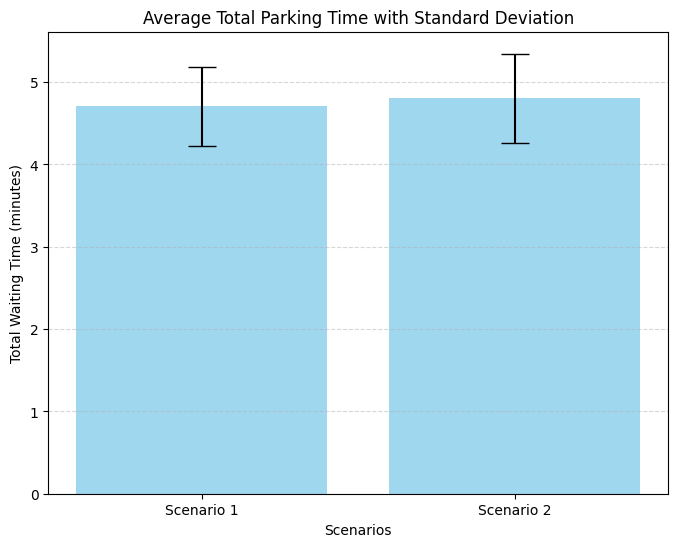

In [11]:
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import deque


# 시뮬레이션 설정
SIMULATION_TIME = 600   # 총 시뮬레이션 시간 (분)
WARMUP_TIME = 240       # 웜업 시간 (4시간)
CAR_ARRIVAL_INTERVAL = 0.5  # 차량 도착 간격 평균 (분)
PARKING_DURATION = [30, 90]  # 주차 시간 범위 (분)
TOTAL_PARKING_SPOTS = 208

# 구역별 주차 공간 설정 (7개 구역)
base_zones_scenario_1 = {"All": {"capacity": TOTAL_PARKING_SPOTS, "occupied": 0}}
base_zones_scenario_2 = {
    "A": {"capacity": 32, "occupied": 0},
    "B": {"capacity": 32, "occupied": 0},
    "C": {"capacity": 32, "occupied": 0},
    "D": {"capacity": 32, "occupied": 0},
    "E": {"capacity": 32, "occupied": 0},
    "F": {"capacity": 32, "occupied": 0},
    "G": {"capacity": 16, "occupied": 0},
}

# 데이터 저장용
# assignment_time: 도착 → 대기 → 주차장 그리드에 차 넣을 때까지 걸린 시간
results = {
    "scenario_1": {"time": [], "occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
    "scenario_2": {"time": [], "total_occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
}

def bfs_parking(parking_lot):
    queue = deque()
    for zone_name, zone in parking_lot.items():
        if zone["occupied"] < zone["capacity"]:
            queue.append(zone_name)
    if queue:
        zone_name = queue.popleft()
        return zone_name
    else:
        return None

def car(env, car_id, parking_lot, result_data, scenario):
    arrival_time = env.now
    waiting_time_start = env.now
    MAX_WAITING_TIME = 30 # 대기 시간 최대 한도 (분)
    zone_name = bfs_parking(parking_lot)

# 빈 자리 찾을 때까지 대기
    while not zone_name:
        yield env.timeout(1)
        if env.now - waiting_time_start > MAX_WAITING_TIME:
            # 대기 초과 시 포기
            #print(f"[상황 {scenario}] 차량 {car_id} 대기 초과로 포기. 대기: {round(env.now - waiting_time_start, 2)}분")  # 가독성을 위해 생략가능
            return
        zone_name = bfs_parking(parking_lot)

    waiting_time = env.now - waiting_time_start
    result_data["waiting_time"].append(waiting_time)

    # 차량 배치 완료
    parking_lot[zone_name]["occupied"] += 1
    assignment_time = env.now - arrival_time
    result_data["assignment_time"].append(assignment_time)

    parking_time = random.randint(*PARKING_DURATION)
    result_data["parking_time"].append(parking_time)

    yield env.timeout(parking_time)
    parking_lot[zone_name]["occupied"] -= 1
    # 상황별 메시지 가독성을 위해 주석처리
    #print(f"[상황 {scenario}] 차량 {car_id} 출차. 주차:{round(parking_time, 2)}분 대기:{round(waiting_time, 2)}분 배치시간:{round(assignment_time, 2)}분")


def simulate_scenario_1(env, parking_lot, result_data):
    car_id = 0
    while env.now < SIMULATION_TIME:
        yield env.timeout(random.expovariate(1.0 / CAR_ARRIVAL_INTERVAL))
        car_id += 1
        env.process(car(env, car_id, parking_lot, result_data, scenario=1))
        result_data["time"].append(env.now)
        result_data["occupancy"].append(parking_lot["All"]["occupied"])

def simulate_scenario_2(env, parking_lot, result_data):
    car_id = 0
    while env.now < SIMULATION_TIME:
        yield env.timeout(random.expovariate(1.0 / CAR_ARRIVAL_INTERVAL))
        car_id += 1
        env.process(car(env, car_id, parking_lot, result_data, scenario=2))
        result_data["time"].append(env.now)
        result_data["total_occupancy"].append(sum(zone["occupied"] for zone in parking_lot.values()))

def run_single_simulation():
    # 매 실행마다 초기화
    results = {
        "scenario_1": {"time": [], "occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
        "scenario_2": {"time": [], "total_occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
    }

    # 각 시나리오에 맞는 parking lot 초기화
    zones_1 = {k: v.copy() for k, v in base_zones_scenario_1.items()}
    zones_2 = {k: v.copy() for k, v in base_zones_scenario_2.items()}

    # 상황 1
    env_1 = simpy.Environment()
    env_1.process(simulate_scenario_1(env_1, zones_1, results["scenario_1"]))
    env_1.run(until=WARMUP_TIME)
    env_1.process(simulate_scenario_1(env_1, zones_1, results["scenario_1"]))
    env_1.run(until=WARMUP_TIME + SIMULATION_TIME)

    # 상황 2
    env_2 = simpy.Environment()
    env_2.process(simulate_scenario_2(env_2, zones_2, results["scenario_2"]))
    env_2.run(until=WARMUP_TIME)
    env_2.process(simulate_scenario_2(env_2, zones_2, results["scenario_2"]))
    env_2.run(until=WARMUP_TIME + SIMULATION_TIME)

    # 단일 시뮬레이션 결과 계산
    avg_waiting_time_1 = np.mean(results["scenario_1"]["waiting_time"]) if results["scenario_1"]["waiting_time"] else 0
    avg_waiting_time_2 = np.mean(results["scenario_2"]["waiting_time"]) if results["scenario_2"]["waiting_time"] else 0
    std_assignment_time_1 = np.std(results["scenario_1"]["assignment_time"]) if results["scenario_1"]["assignment_time"] else 0
    std_assignment_time_2 = np.std(results["scenario_2"]["assignment_time"]) if results["scenario_2"]["assignment_time"] else 0
    # 중앙값 계산
    median_waiting_time_1 = np.median(results["scenario_1"]["waiting_time"]) if results["scenario_1"]["waiting_time"] else 0
    median_waiting_time_2 = np.median(results["scenario_2"]["waiting_time"]) if results["scenario_2"]["waiting_time"] else 0


    return avg_waiting_time_1, avg_waiting_time_2, std_assignment_time_1, std_assignment_time_2, median_waiting_time_1, median_waiting_time_2
    results

def run_multiple_simulations(n_runs=50):
    waiting_times_1 = []
    waiting_times_2 = []
    assignment_std_1 = []
    assignment_std_2 = []
    median_times_1 = []
    median_times_2 = []

    for i in range(n_runs):
        w1, w2, a1, a2, m1, m2= run_single_simulation()
        waiting_times_1.append(w1)
        waiting_times_2.append(w2)
        assignment_std_1.append(a1)
        assignment_std_2.append(a2)
        median_times_1.append(m1)
        median_times_2.append(m2)


    # 결과 요약
    print(f"<비교분석을 위한 단일 시행, 데이터 추출>")
    print(f"[Scenario 1] 대기시간, 평균:{np.mean(waiting_times_1):.2f}분 (중앙값:{np.mean(median_times_1):.2f}분)")
    print(f"[Scenario 2] 대기시간, 평균:{np.mean(waiting_times_2):.2f}분 (중앙값:{np.mean(median_times_2):.2f}분)")
    print(f"[Scenario 1] 총 주차시간, 평균:{np.mean(assignment_std_1):.2f}분, 표준편차:{np.std(assignment_std_1):.2f}")
    print(f"[Scenario 2] 총 주차시간, 평균:{np.mean(assignment_std_2):.2f}분, 표준편차:{np.std(assignment_std_2):.2f}")

    print(f"\n--- {n_runs}회 시뮬레이션 결과 요약 ---\n")
    print(f"\n<50번 시행 데이터 추출기반, 그래프>")
    # 에러바 그래프
    categories = ['Scenario 1', 'Scenario 2']
    avg_assignment_times = [np.mean(assignment_std_1), np.mean(assignment_std_2)]
    std_assignment_times = [np.std(assignment_std_1), np.std(assignment_std_2)]
    avg_waiting_times = [np.mean(waiting_times_1), np.mean(waiting_times_2)]
    std_waiting_times = [np.std(waiting_times_1), np.std(waiting_times_2)]

    plt.figure(figsize=(8, 6))
    plt.bar(categories, avg_waiting_times, yerr=std_waiting_times, capsize=10, color='skyblue', alpha=0.8)
    plt.title('Average Total Parking Time with Standard Deviation')
    plt.ylabel('Total Waiting Time (minutes)')
    plt.xlabel('Scenarios')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()



if __name__ == "__main__":
    run_multiple_simulations(n_runs=50)


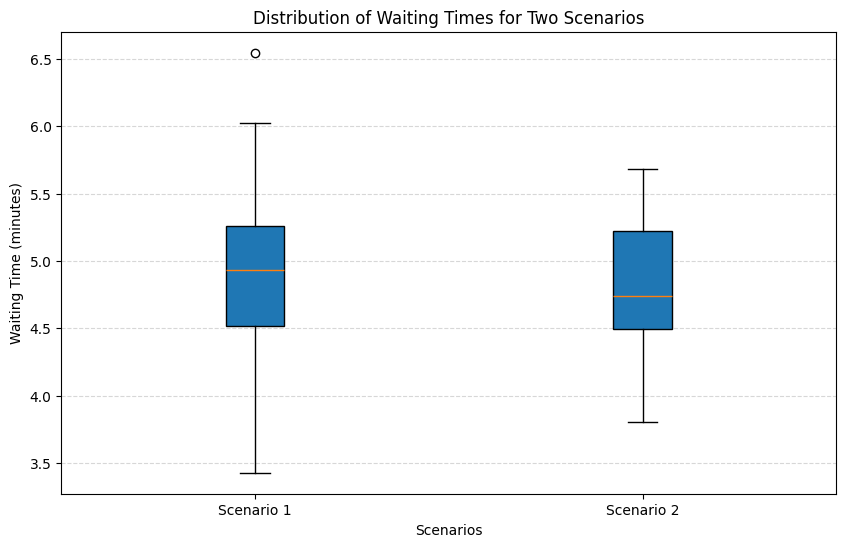

In [12]:
import matplotlib.pyplot as plt

def boxplot_visualization():
    waiting_times_1 = []
    waiting_times_2 = []

    for _ in range(50):  # 50회 실행
        w1, w2, _, _, _, _ = run_single_simulation()
        waiting_times_1.append(w1)
        waiting_times_2.append(w2)

    # 박스플롯 그리기
    plt.figure(figsize=(10, 6))
    plt.boxplot([waiting_times_1, waiting_times_2], labels=['Scenario 1', 'Scenario 2'], patch_artist=True)

    # 그래프 제목 및 라벨 추가
    plt.title('Distribution of Waiting Times for Two Scenarios')
    plt.ylabel('Waiting Time (minutes)')
    plt.xlabel('Scenarios')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # 박스플롯 표시
    plt.show()

if __name__ == "__main__":
    boxplot_visualization()


# **150회시행**

In [13]:
import simpy
import random
import numpy as np
from collections import deque

# 시뮬레이션 설정
SIMULATION_TIME = 600  # 총 시뮬레이션 시간 (분)
WARMUP_TIME = 240   # 웜업 시간 (4시간)
CAR_ARRIVAL_INTERVAL = 0.5  # 차량 도착 간격 평균 (분)
PARKING_DURATION = [30, 90]  # 주차 시간 범위 (분)
TOTAL_PARKING_SPOTS = 208

# 구역별 주차 공간 설정 (7개 구역)
zones_scenario_1 = {"All": {"capacity": TOTAL_PARKING_SPOTS, "occupied": 0}}
zones_scenario_2 = {
    "A": {"capacity": 32, "occupied": 0},
    "B": {"capacity": 32, "occupied": 0},
    "C": {"capacity": 32, "occupied": 0},
    "D": {"capacity": 32, "occupied": 0},
    "E": {"capacity": 32, "occupied": 0},
    "F": {"capacity": 32, "occupied": 0},
    "G": {"capacity": 16, "occupied": 0},
}

# 데이터 저장용
# assignment_time: 도착 → 대기 → 주차장 그리드에 차 넣을 때까지 걸린 시간
results = {
    "scenario_1": {"time": [], "occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
    "scenario_2": {"time": [], "total_occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
}

def bfs_parking(parking_lot):
    queue = deque()
    for zone_name, zone in parking_lot.items():
        if zone["occupied"] < zone["capacity"]:
            queue.append(zone_name)

    if queue:
        zone_name = queue.popleft()
        return zone_name
    else:
        return None  # 주차 공간이 없음

def car(env, car_id, parking_lot, result_data, scenario):
    arrival_time = env.now
    waiting_time_start = env.now
    MAX_WAITING_TIME = 30  # 대기 시간 최대 한도 (분)
    zone_name = bfs_parking(parking_lot)

    # 빈 자리 찾을 때까지 대기
    while not zone_name:
        yield env.timeout(1)
        if env.now - waiting_time_start > MAX_WAITING_TIME:
            # 대기 초과 시 포기
            #print(f"[상황 {scenario}] 차량 {car_id} 대기 초과로 포기. 대기: {round(env.now - waiting_time_start, 2)}분")
            return
        zone_name = bfs_parking(parking_lot)

    # 대기 시간
    waiting_time = env.now - waiting_time_start
    result_data["waiting_time"].append(waiting_time)

    # 차를 주차장 그리드에 넣는 순간 (점유 시작)
    parking_lot[zone_name]["occupied"] += 1
    # 이 시점이 곧 '도착→대기→그리드 배치' 완료 시점
    assignment_time = env.now - arrival_time
    result_data["assignment_time"].append(assignment_time)

    # 주차 시간 (차량이 주차장에 머무는 시간)
    parking_time = random.randint(*PARKING_DURATION)
    result_data["parking_time"].append(parking_time)

    yield env.timeout(parking_time)

    # 차량 출차
    parking_lot[zone_name]["occupied"] -= 1

    # 상황별 메시지
    #print(f"[상황 {scenario}] 차량 {car_id} 출차. 주차:{round(parking_time, 2)}분 대기:{round(waiting_time, 2)}분 배치시간:{round(assignment_time, 2)}분")

def simulate_scenario_1(env, parking_lot, result_data):
    car_id = 0
    while env.now < SIMULATION_TIME:
        yield env.timeout(random.expovariate(1.0 / CAR_ARRIVAL_INTERVAL))
        car_id += 1
        env.process(car(env, car_id, parking_lot, result_data, scenario=1))
        result_data["time"].append(env.now)
        result_data["occupancy"].append(parking_lot["All"]["occupied"])

def simulate_scenario_2(env, parking_lot, result_data):
    car_id = 0
    while env.now < SIMULATION_TIME:
        yield env.timeout(random.expovariate(1.0 / CAR_ARRIVAL_INTERVAL))
        car_id += 1
        env.process(car(env, car_id, parking_lot, result_data, scenario=2))
        result_data["time"].append(env.now)
        result_data["total_occupancy"].append(sum(zone["occupied"] for zone in parking_lot.values()))

def run_single_simulation():
    # 매 실행마다 초기화
    results = {
        "scenario_1": {"time": [], "occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
        "scenario_2": {"time": [], "total_occupancy": [], "waiting_time": [], "parking_time": [], "assignment_time": []},
    }

    # 각 시나리오에 맞는 parking lot 초기화
    zones_1 = {k: v.copy() for k, v in zones_scenario_1.items()}
    zones_2 = {k: v.copy() for k, v in zones_scenario_2.items()}

    # 상황 1
    env_1 = simpy.Environment()
    env_1.process(simulate_scenario_1(env_1, zones_1, results["scenario_1"]))
    env_1.run(until=WARMUP_TIME)
    env_1.process(simulate_scenario_1(env_1, zones_1, results["scenario_1"]))
    env_1.run(until=WARMUP_TIME + SIMULATION_TIME)

    # 상황 2
    env_2 = simpy.Environment()
    env_2.process(simulate_scenario_2(env_2, zones_2, results["scenario_2"]))
    env_2.run(until=WARMUP_TIME)
    env_2.process(simulate_scenario_2(env_2, zones_2, results["scenario_2"]))
    env_2.run(until=WARMUP_TIME + SIMULATION_TIME)

    return results

def run_multiple_simulations(n_runs=150):
    all_results_1 = []  # Scenario 1의 모든 결과 저장
    all_results_2 = []  # Scenario 2의 모든 결과 저장

    for i in range(n_runs):
        results = run_single_simulation()  # 단일 시뮬레이션 실행

        # Scenario 1과 Scenario 2의 데이터를 추출하여 저장
        avg_waiting_time_1 = np.mean(results["scenario_1"]["waiting_time"]) if results["scenario_1"]["waiting_time"] else 0
        avg_waiting_time_2 = np.mean(results["scenario_2"]["waiting_time"]) if results["scenario_2"]["waiting_time"] else 0
        std_assignment_time_1 = np.std(results["scenario_1"]["assignment_time"]) if results["scenario_1"]["assignment_time"] else 0
        std_assignment_time_2 = np.std(results["scenario_2"]["assignment_time"]) if results["scenario_2"]["assignment_time"] else 0

        all_results_1.append({"waiting_time": avg_waiting_time_1, "assignment_std": std_assignment_time_1})
        all_results_2.append({"waiting_time": avg_waiting_time_2, "assignment_std": std_assignment_time_2})

    # 결과 요약 출력
    avg_waiting_time_1 = np.mean([r["waiting_time"] for r in all_results_1])
    avg_waiting_time_2 = np.mean([r["waiting_time"] for r in all_results_2])
    avg_assignment_std_1 = np.mean([r["assignment_std"] for r in all_results_1])
    avg_assignment_std_2 = np.mean([r["assignment_std"] for r in all_results_2])
    assignment_std_1 = [r["assignment_std"] for r in all_results_1]
    assignment_std_2 = [r["assignment_std"] for r in all_results_2]

    print(f"\n--- {n_runs}회 시뮬레이션 결과 요약 ---\n")
    print(f"Scenario 1 대기시간: 평균:{avg_waiting_time_1:.2f}분")
    print(f"Scenario 2 대기시간 평균:{avg_waiting_time_2:.2f}분")
    print(f"Scenario 1 총 주차시간: 평균:{avg_assignment_std_1:.2f}분, 표준편차:{np.std(assignment_std_1):.2f}")
    print(f"Scenario 2 총 주차시간: 평균:{avg_assignment_std_2:.2f}분, 표준편차:{np.std(assignment_std_2):.2f}")

    # 전체 결과 반환
    return all_results_1, all_results_2


if __name__ == "__main__":
    all_results_1, all_results_2 = run_multiple_simulations(n_runs=150)

    # 예: 첫 번째 시행의 대기 시간 확인
    print(f"\n\n<단일 시행과의 비교분석>")
    print(f"첫 번째 시행 Scenario 1 대기시간: {all_results_1[0]['waiting_time']}분")
    print(f"첫 번째 시행 Scenario 2 대기시간: {all_results_2[0]['waiting_time']}분")

    # 모든 데이터를 활용한 추가 분석 가능



--- 150회 시뮬레이션 결과 요약 ---

Scenario 1 대기시간: 평균:4.84분
Scenario 2 대기시간 평균:4.82분
Scenario 1 총 주차시간: 평균:7.19분, 표준편차:0.38
Scenario 2 총 주차시간: 평균:7.16분, 표준편차:0.37


<단일 시행과의 비교분석>
첫 번째 시행 Scenario 1 대기시간: 5.078442128359846분
첫 번째 시행 Scenario 2 대기시간: 4.468858131487889분


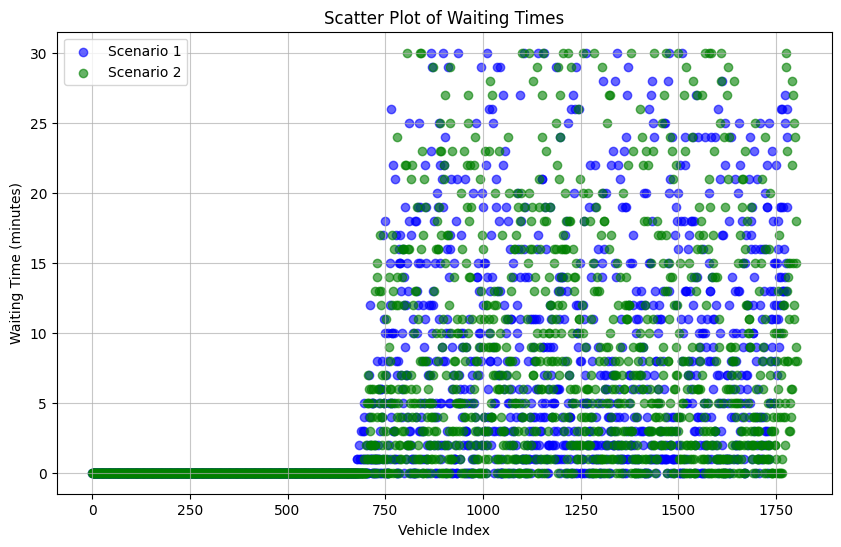

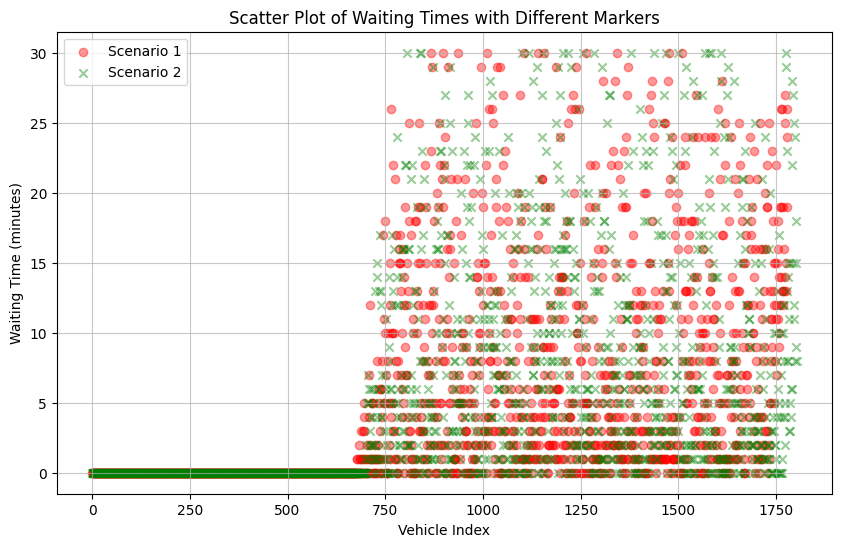

In [14]:
import matplotlib.pyplot as plt

def plot_scatter_results(results):
    # 산점도 1
    plt.figure(figsize=(10, 6))
    plt.scatter(
        range(len(results["scenario_1"]["waiting_time"])),
        results["scenario_1"]["waiting_time"],
        alpha=0.6,
        label="Scenario 1",
        color="blue"
    )
    plt.scatter(
        range(len(results["scenario_2"]["waiting_time"])),
        results["scenario_2"]["waiting_time"],
        alpha=0.6,
        label="Scenario 2",
        color="green"
    )
    plt.title("Scatter Plot of Waiting Times")
    plt.xlabel("Vehicle Index")
    plt.ylabel("Waiting Time (minutes)")
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()

    # 산점도 2 - 서로 다른 마커 추가
    plt.figure(figsize=(10, 6))
    plt.scatter(
        range(len(results["scenario_1"]["waiting_time"])),
        results["scenario_1"]["waiting_time"],
        alpha=0.4,
        label="Scenario 1",
        color="red",
        marker="o"  # Scenario 1: 원형 마커
    )
    plt.scatter(
        range(len(results["scenario_2"]["waiting_time"])),
        results["scenario_2"]["waiting_time"],
        alpha=0.4,
        label="Scenario 2",
        color="green",
        marker="x"  # Scenario 2: X형 마커
    )
    plt.title("Scatter Plot of Waiting Times with Different Markers")
    plt.xlabel("Vehicle Index")
    plt.ylabel("Waiting Time (minutes)")
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()

# Example usage
if __name__ == "__main__":
    # results 데이터를 전달하여 실행
    results = run_single_simulation()  # run_single_simulation의 결과를 사용
    plot_scatter_results(results)
